In [1]:
%load_ext autoreload
%autoreload 2
import torch
from data.cifar10 import CIFAR10C, CIFAR10CFrostFogSnow, CIFAR10DataModule
from PIL import Image
from tqdm.notebook import tqdm
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from utils.image_transforms import UnNormalize
from torchvision.transforms import transforms
import numpy as np
from os.path import join
from models.classifier import TorchvisionClassifier

In [2]:
ims = torch.load('/voyager/datasets/CIFAR-10-C/frost-fog-snow.pt')

In [3]:
un = UnNormalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
tf = transforms.Compose([un, transforms.ToPILImage()])

In [4]:
def pil_image_grid(images: list[Image], n, k):
    # make a grid of pil images
    grid = Image.new('RGB', (n * 32, k * 32))
    for i, im in enumerate(images):
        grid.paste(im, (i % n * 32, i // n * 32))
    return grid


# 20 random images
idx = sample(range(len(ims)), 20)
images = [tf(im) for im in ims[idx]]
grid = pil_image_grid(images, n=10, k=2)

In [19]:
shift_types = ('frost', 'fog', 'snow')
_images = [np.load(join('/voyager/datasets', 'CIFAR-10-C', x + '.npy')) for x in shift_types]

In [5]:
# import torchvision
# cif = torchvision.datasets.CIFAR10(root='/voyager/datasets/', train=False, download=False)
model = TorchvisionClassifier(out_features=10)

In [6]:
sd = torch.load('/voyager/projects/tomginsberg/pqlearning/checkpoints/cifar/cifar10_resnet18/epoch=197-step=77417.ckpt')['state_dict']

In [7]:
model.load_state_dict(sd)

<All keys matched successfully>

In [11]:
c10_1 = np.load('/voyager/datasets/cifar-10-1/cifar10.1_v6_data.npy')
c10_1_l = np.load('/voyager/datasets/cifar-10-1/cifar10.1_v6_labels.npy')

In [14]:
c10_1_l = torch.from_numpy(c10_1_l)
c10_1 = torch.from_numpy(c10_1).permute(0, 3, 1, 2)

In [20]:
c10_1 = torch.stack([transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(x/255) for x in c10_1])

In [22]:
torch.save(c10_1, '/voyager/datasets/cifar-10-1/cifar10.1_v6_data.pt')
torch.save(c10_1_l, '/voyager/datasets/cifar-10-1/cifar10.1_v6_labels.pt')

In [21]:
labels = []
preds = []
ds = zip(c10_1, c10_1_l)
model.eval()
with torch.no_grad():
    for im, label in tqdm(ds):
        im = im.unsqueeze(0)
        pred = model(im)
        pred = pred.argmax(dim=1)
        preds.append(pred.item())
        labels.append(label)

labels = np.array(labels)
preds = np.array(preds)

print(f'Accuracy: {np.mean(preds == labels)}')

0it [00:00, ?it/s]

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy: 0.766


In [83]:
labels = []
preds = []
ds = CIFAR10DataModule(shift=False, negative_labels=False, shift_types=['frost']).val
model.eval()
with torch.no_grad():
    for im, label in tqdm(ds):
        im = im.unsqueeze(0)
        pred = model(im)
        pred = pred.argmax(dim=1)
        preds.append(pred.item())
        labels.append(label)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [84]:
labels = np.array(labels)
preds = np.array(preds)

print(f'Accuracy: {np.mean(preds == labels)}')

Accuracy: 0.873


In [75]:
labels = []
preds = []
sev = []
cor = []
ds = CIFAR10CFrostFogSnow(negative_labels=False, return_meta=True)
model.eval()
with torch.no_grad():
    for im, (label, severity, corruption) in tqdm(ds):
        im = im.unsqueeze(0)
        pred = model(im)
        pred = pred.argmax(dim=1)
        preds.append(pred.item())
        labels.append(label)
        sev.append(severity)
        cor.append(corruption)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [80]:
labels = np.array(labels)
preds = np.array(preds)
sev = np.array(sev)
cor = np.array(cor)
print(f'Accuracy: {np.mean(preds == labels)}')
for s in np.unique(sev):
    print(f'Severity {s}: {np.mean(preds[sev == s] == labels[sev == s])}')

for c in np.unique(cor):
    print(f'Corruption {c}: {np.mean(preds[cor == c] == labels[cor == c])}')

Accuracy: 0.7267
Severity 2: 0.78688019710502
Severity 3: 0.740251949610078
Severity 4: 0.6563322608949985
Corruption 0: 0.7601796407185629
Corruption 1: 0.657566765578635
Corruption 2: 0.7635258358662614


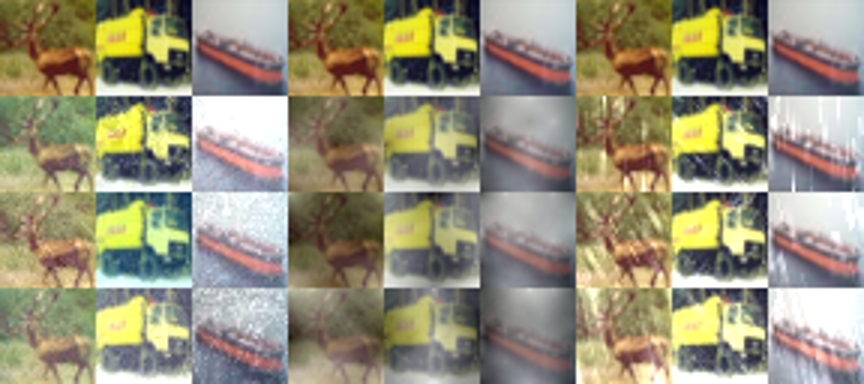

In [56]:
idx = [3203, 9072, 999]

for i in idx:
    for k in range(3):
        _images[k][i] = cif[i][0]

ims = [Image.fromarray(_images[k][i + 10000 * (s - 1)]) for s in [1, 3, 4, 5] for k in range(3) for i in idx]
im = pil_image_grid(ims, n=9, k=4)
im.resize((im.width * 3, im.height * 3))

In [23]:
labels = pd.read_csv(join('/voyager/datasets', 'CIFAR-10-C', 'frost-fog-snow.csv'))

In [27]:
labels.iloc[range(0, 10000, 10)].iloc[2]

label         1
severity      2
corruption    2
Name: 20, dtype: int64